<a href="https://colab.research.google.com/github/evelinmus/cse120-2021-api/blob/main/Homework_4_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
%pip install ftfy
import ftfy
import unicodedata
import re
import umap
import datetime as dt
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.proportion import proportions_ztest
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.neighbors import LocalOutlierFactor
import spacy
nlp = spacy.load("en_core_web_sm")
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import lightgbm as lgb
!pip install pandas=='1.5.3' numpy=='1.26.4' scikit-learn=='1.5.0' transformers=='4.41.2' sentence_transformers=='3.2.1' tensorflow=='2.19.0'
import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv('/content/books_data.csv')

## Data Sanity Checks

In [3]:
df.shape

(6810, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6810 entries, 0 to 6809
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   isbn13          6810 non-null   int64  
 1   isbn10          6810 non-null   object 
 2   title           6810 non-null   object 
 3   subtitle        2381 non-null   object 
 4   authors         6738 non-null   object 
 5   categories      6711 non-null   object 
 6   thumbnail       6481 non-null   object 
 7   published_year  6804 non-null   float64
 8   average_rating  6767 non-null   float64
 9   num_pages       6767 non-null   float64
 10  ratings_count   6767 non-null   float64
 11  description     6548 non-null   object 
dtypes: float64(4), int64(1), object(7)
memory usage: 638.6+ KB


In [5]:
df.head()

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,published_year,average_rating,num_pages,ratings_count,description
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,2004.0,3.85,247.0,361.0,a NVOEL THAt READERS and critisc have bene eag...
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,2000.0,3.83,241.0,5164.0,"A new 'Chistie,r for Cristmas'h -- a full-leng..."
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,1982.0,3.97,479.0,172.0,Volume Two of? Stephen Dnaldson'so acclaiedm s...
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,1993.0,3.93,512.0,29532.0,"A memoRable, mesmerizing heroine Jennifer -- b..."
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,2002.0,4.15,170.0,33684.0,Lewis' wrko on <br>the </p>naTure of loev divi...


In [6]:
# Checking for missing values
print("Missing values:")
df.isna().sum()

Missing values:


,0
isbn13,0
isbn10,0
title,0
subtitle,4429
authors,72
categories,99
thumbnail,329
published_year,6
average_rating,43
num_pages,43


In [7]:

#I decided to drop the column "subtitles" as it is mostly NA and will not be usefull for our analysis
df.drop(columns="subtitle", inplace=True)

In [8]:
# Checking for missing values
print("Missing values:")
df.isna().sum()

Missing values:


,0
isbn13,0
isbn10,0
title,0
authors,72
categories,99
thumbnail,329
published_year,6
average_rating,43
num_pages,43
ratings_count,43


In [9]:
# drop missing values
df = df.dropna()

In [10]:
df.shape

(6215, 11)

In [11]:
# no duplicates
df.duplicated().sum()

0

In [12]:

# average_rating should be between 0 and 5:
invalid_ratings = df[~df.average_rating.between(0, 5)]
invalid_ratings

,isbn13,isbn10,title,authors,categories,thumbnail,published_year,average_rating,num_pages,ratings_count,description


In [13]:

# define your lower & upper bounds
min_year, max_year = 1450, 2024

# filter for anything outside that range
bad_years = df[~df['published_year'].between(min_year, max_year)]

# view just the key columns for clarity
print(bad_years[['isbn13', 'title', 'published_year']])

bad_years = df[(df['published_year'] < min_year) | (df['published_year'] > max_year)]
bad_years[['isbn13', 'title', 'published_year']]

Empty DataFrame
Columns: [isbn13, title, published_year]
Index: []


,isbn13,title,published_year


In [14]:
# To check realisitc number of pages we first set our threshold
threshold = 4000

# select all rows where num_pages is greater than threshold
too_long = df[df['num_pages'] > threshold]

df[df['num_pages'] > threshold]

,isbn13,isbn10,title,authors,categories,thumbnail,published_year,average_rating,num_pages,ratings_count,description


In [15]:
#Ensure all ISBN-13 strings are 13 digits and ISBN-10 are 10 digits (no stray letters/spaces):
df['isbn13_str'] = df['isbn13'].astype(str).str.zfill(13)
bad_isbn13 = df[~df['isbn13_str'].str.match(r'^\d{13}$')]
bad_isbn13

,isbn13,isbn10,title,authors,categories,thumbnail,published_year,average_rating,num_pages,ratings_count,description,isbn13_str


In [16]:
# First clean out dashes/spaces and uppercase everything:
df['isbn10_clean'] = (
    df['isbn10']
    .str.replace(r'[\-\s]', '', regex=True)
    .str.upper()
)

# Then validate 9 digits + [0–9 or X]:
bad_isbn10 = df[~df['isbn10_clean'].str.match(r'^\d{9}[\dX]$')]

# And if you want to keep only the valid ones:
df = df[df['isbn10_clean'].str.match(r'^\d{9}[\dX]$')]
bad_isbn10

,isbn13,isbn10,title,authors,categories,thumbnail,published_year,average_rating,num_pages,ratings_count,description,isbn13_str,isbn10_clean


In [17]:
#Quick check that thumbnail URLs at least start with “http
bad_urls = df[~df.thumbnail.str.startswith('http')]
bad_urls

,isbn13,isbn10,title,authors,categories,thumbnail,published_year,average_rating,num_pages,ratings_count,description,isbn13_str,isbn10_clean


In [18]:
try:
    import ftfy
    fix_text = ftfy.fix_text
except ImportError:
    fix_text = lambda x: x  # no-op if ftfy isn't there
df['authors_orig'] = df['authors']

def clean_authors(name):
    if pd.isna(name):
        return name
    # 1. repair double-encoded text (mojibake → correct)
    repaired = fix_text(name)
    # 2. decompose combining marks so our isalnum() check is more consistent
    normalized = unicodedata.normalize('NFKC', repaired)
    # 3. rebuild string keeping ONLY:
    #    - any letter/digit (Unicode .isalnum())
    #    - space, semicolon, apostrophe, comma, period, hyphen
    cleaned = ''.join(
        ch for ch in normalized
        if ch.isalnum()
           or ch in {" ", ";", "'", ",", ".", "-"}
    )
    # 4. tidy up semicolon spacing and collapse any multi-spaces
    cleaned = re.sub(r'\s*;\s*', '; ', cleaned).strip()
    cleaned = re.sub(r'\s{2,}', ' ', cleaned)
    return cleaned

df['authors_clean'] = df['authors'].apply(clean_authors)

# show only real changes (no NAs)
changes = df.loc[
    df['authors_orig'].notna() &
    df['authors_clean'].notna() &
    (df['authors_orig'] != df['authors_clean']),
    ['isbn13','title','authors_orig','authors_clean']
]
display_df = (
    changes
    .loc[:, ['authors_orig','authors_clean']]
    .rename(columns={
        'authors_orig': 'Original Author',
        'authors_clean': 'Corrected Author'
    })
)

display(display_df)
df.drop(columns=['authors_orig','authors_clean'], inplace=True)

,Original Author,Corrected Author
1,Charles Osborne;Agatha Christie,Charles Osborne; Agatha Christie
14,Raymond E. Feist;Joel Rosenberg,Raymond E. Feist; Joel Rosenberg
15,Raymond E. Feist;S. M. Stirling,Raymond E. Feist; S. M. Stirling
30,Jessica Adams;Chris Manby;Fiona Walker,Jessica Adams; Chris Manby; Fiona Walker
35,Mark Haddon;Peter Sutton,Mark Haddon; Peter Sutton
...,...,...
6779,Rob Thomas;Leah Wilson,Rob Thomas; Leah Wilson
6789,Joseph Cornell;Alison Baverstock,Joseph Cornell; Alison Baverstock
6795,武蔵·宮本,武蔵宮本
6805,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Sri Nisargadatta Maharaj; Sudhakar S. Dikshit


In [19]:
# no duplicates
df.duplicated().sum()

0

In [20]:
# from here we can see that there are no negative values
df.describe().T

,count,mean,std,min,25%,50%,75%,max
isbn13,6215.0,9.780665e+12,5.838367e+08,9.780002e+12,9.780316e+12,9.780522e+12,9.780806e+12,9.789042e+12
published_year,6215.0,1.999102e+03,9.725834e+00,1.876000e+03,1.997000e+03,2.002000e+03,2.005000e+03,2.019000e+03
average_rating,6215.0,3.930674e+00,3.221897e-01,0.000000e+00,3.770000e+00,3.950000e+00,4.130000e+00,5.000000e+00
num_pages,6215.0,3.478861e+02,2.329312e+02,0.000000e+00,2.080000e+02,3.080000e+02,4.190000e+02,3.342000e+03
ratings_count,6215.0,2.075841e+04,1.261204e+05,0.000000e+00,1.790000e+02,1.122000e+03,6.559000e+03,5.629932e+06


In [21]:
#Unique value counts
print("Unique Counts")
print("Authors:", df['authors'].nunique())
print("Categories:", df['categories'].nunique())

print("\nTop 5 authors:")
print(df['authors'].value_counts().head())

print("\nTop 5 categories:")
print(df['categories'].str.split('|').explode().value_counts().head())

Unique Counts
Authors: 3552
Categories: 488

Top 5 authors:
Agatha Christie        37
Stephen King           31
William Shakespeare    29
Virginia Woolf         23
Sandra Brown           22
Name: authors, dtype: int64

Top 5 categories:
Fiction                      2455
Juvenile Fiction              503
Biography & Autobiography     382
History                       255
Literary Criticism            161
Name: categories, dtype: int64


## Exploratory Data Analysis (EDA)

In [22]:
df['desc_length'] = df['description'].str.len()

In [23]:
df.head()

,isbn13,isbn10,title,authors,categories,thumbnail,published_year,average_rating,num_pages,ratings_count,description,isbn13_str,isbn10_clean,desc_length
0,9780002005883,0002005883,Gilead,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,2004.0,3.85,247.0,361.0,a NVOEL THAt READERS and critisc have bene eag...,9780002005883,0002005883,1165
1,9780002261982,0002261987,Spider's Web,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,2000.0,3.83,241.0,5164.0,"A new 'Chistie,r for Cristmas'h -- a full-leng...",9780002261982,0002261987,1216
2,9780006163831,0006163831,The One Tree,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,1982.0,3.97,479.0,172.0,Volume Two of? Stephen Dnaldson'so acclaiedm s...,9780006163831,0006163831,126
3,9780006178736,0006178731,Rage of angels,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,1993.0,3.93,512.0,29532.0,"A memoRable, mesmerizing heroine Jennifer -- b...",9780006178736,0006178731,374
4,9780006280897,0006280897,The Four Loves,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,2002.0,4.15,170.0,33684.0,Lewis' wrko on <br>the </p>naTure of loev divi...,9780006280897,0006280897,313


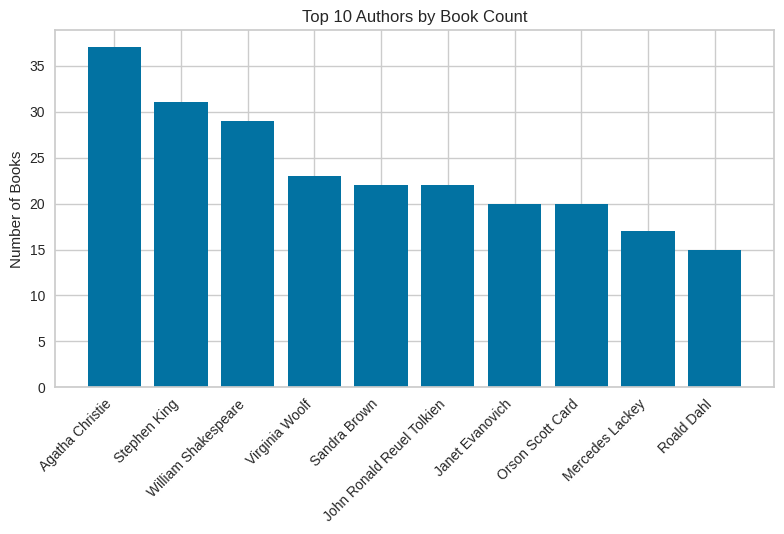

In [24]:
# 1. Top 10 Authors Bar Chart
top_authors = df['authors'].value_counts().head(10)
fig, ax = plt.subplots()
ax.bar(top_authors.index, top_authors.values)
ax.set_xticklabels(top_authors.index, rotation=45, ha='right')
ax.set_title('Top 10 Authors by Book Count')
ax.set_ylabel('Number of Books')
plt.tight_layout()
plt.show()

We can see that the most popular author is Agatha Christie

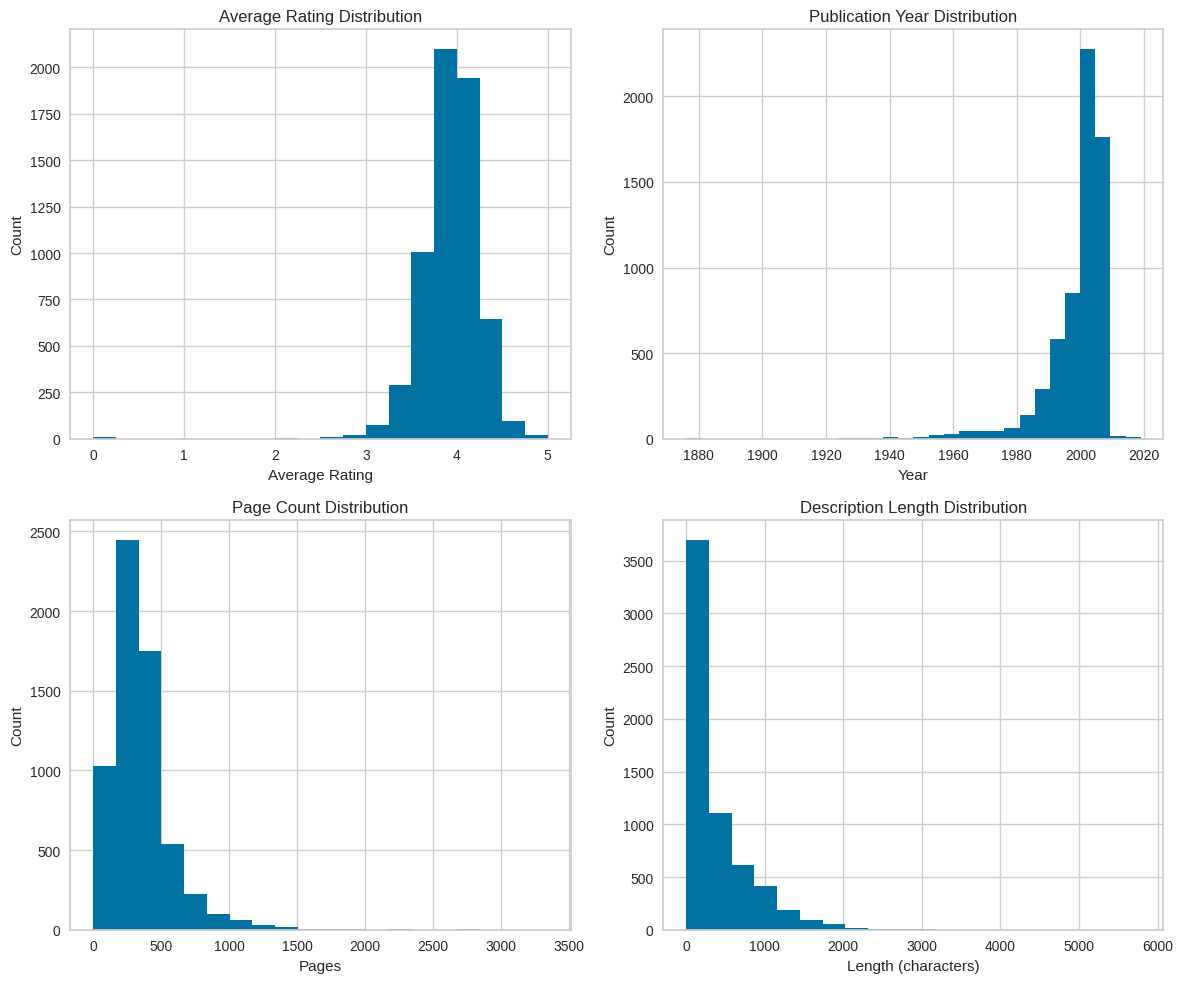

In [25]:
# Numeric summary of key fields
df[['average_rating', 'ratings_count', 'num_pages', 'published_year']].describe()

# Top 10 most frequent categories
df['categories'].value_counts().head(10)

# Add description length for further analysis
df['desc_len'] = df['description'].fillna('').str.len()

# Plot distributions
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.hist(df['average_rating'].dropna(), bins=20)
plt.title('Average Rating Distribution')
plt.xlabel('Average Rating')
plt.ylabel('Count')

plt.subplot(2, 2, 2)
plt.hist(df['published_year'].dropna(), bins=30)
plt.title('Publication Year Distribution')
plt.xlabel('Year')
plt.ylabel('Count')

plt.subplot(2, 2, 3)
plt.hist(df['num_pages'].dropna(), bins=20)
plt.title('Page Count Distribution')
plt.xlabel('Pages')
plt.ylabel('Count')

plt.subplot(2, 2, 4)
plt.hist(df['desc_len'], bins=20)
plt.title('Description Length Distribution')
plt.xlabel('Length (characters)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

Distributional Plots
**Average Rating Histogram**

A clear peak around 3.8–4.2 stars.

Very few extremely low or perfect scores.

**Publication Year Histogram**

Sharp rise in titles from the 1980s onward, peaking in the 2000s–2010s.

Only a sprinkling of pre-1900 works.

**Page Count Histogram**

Most books cluster between ~100–500 pages.

“Novellas” (< 100 pages) appear but are a minority; epics (> 1,000 pages) are rare outliers.

**Description Length**

(If you added it) you’ll see many books have descriptions in the few‐hundred‐character range, with a tail of very short (empty) and very long entries.

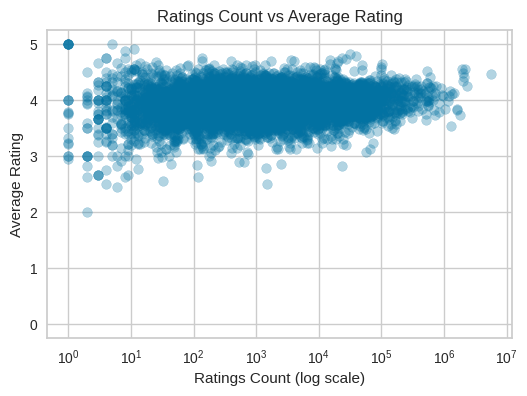

In [26]:
# Scatter plot: popularity vs. rating
plt.figure(figsize=(6, 4))
plt.scatter(df['ratings_count'], df['average_rating'], alpha=0.3)
plt.xscale('log')
plt.title('Ratings Count vs Average Rating')
plt.xlabel('Ratings Count (log scale)')
plt.ylabel('Average Rating')
plt.show()

There’s a slight upward drift: books with more ratings tend to have marginally higher average scores—suggesting that best-sellers not only get read more but also reviewed more kindly.

But the cloud is still wide: you’ll find less-popular gems and massively popular duds.

## NLP on Description column

In [27]:
import spacy
nlp = spacy.load("en_core_web_sm")
from functools import lru_cache
from nltk.stem import SnowballStemmer, PorterStemmer
snow_stemmer = SnowballStemmer(language='english')
from bs4 import BeautifulSoup
from textblob import Word
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [28]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
# Initialize tools
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

In [30]:
# 2) Backup original descriptions if you like
df['desc_orig'] = df['description']


In [31]:
# 3) Prepare spell-corrector with caching
@lru_cache(maxsize=100000)
def correct_spelling(w: str) -> str:
    return str(Word(w).correct())

In [36]:
# 4) Stopwords & stemmer
stop_words = set('ENGLISH_STOP_WORDS')
ps = PorterStemmer()

In [33]:
# 5) Cleaning function
def clean_description(text: str) -> str:
    if pd.isna(text):
        return ""
    # a) Strip HTML
    raw = BeautifulSoup(text, 'html.parser').get_text()
    # b) Lowercase
    raw = raw.lower()
    # c) Remove URLs & non-letters
    raw = re.sub(r'http\S+|www\.\S+', " ", raw)
    raw = re.sub(r'[^a-z\s]', " ", raw)
    # d) Tokenize
    tokens = raw.split()
    # e) Stop-word removal
    tokens = [t for t in tokens if t not in stop_words]
    # f) Spelling correction
    tokens = [correct_spelling(t) for t in tokens]
    # g) Stemming
    tokens = [ps.stem(t) for t in tokens]
    # h) Rejoin
    return " ".join(tokens)

In [34]:
# 6) Apply to  DataFrame
df['description_clean'] = df['description'].apply(clean_description)

KeyboardInterrupt: 

In [ ]:
# 7) Quick before/after check
for orig, clean in zip(df['desc_orig'].head(3), df['description_clean'].head(3)):
    print("ORIGINAL:", orig)
    print("CLEANED: ", clean, "\n")


## NER on first 500

In [35]:
# Load spaCy’s English model
nlp = spacy.load("en_core_web_sm")

# Prepare the corpus: join the first 500 non-null descriptions
texts = df['description'].dropna().head(500).tolist()
corpus = " ".join(texts)

# Run NER
doc = nlp(corpus)

# Extract and count labels
labels = [ent.label_ for ent in doc.ents]
counts = pd.Series(labels).value_counts()

# Display counts
print("Entity counts:\n", counts, "\n")

Entity counts:
 PERSON         1318
ORG             883
GPE             418
CARDINAL        396
DATE            348
NORP            209
WORK_OF_ART     126
ORDINAL         113
LOC              82
PRODUCT          68
TIME             37
FAC              30
EVENT            24
MONEY            12
LANGUAGE         11
LAW               8
QUANTITY          8
dtype: int64 



In [37]:
fig = px.bar(
    x=counts.index,
    y=counts.values,
    labels={'x':'Entity Type','y':'Frequency'},
    title='NER Entity Counts (first 500 descriptions)'
)

fig.show()

5. Prepare data (the full data) for category classification

In [38]:
# ——— 5a) Create target label Y ———
# Mark as 1 if the category string contains “fiction” (case-insensitive), else 0.
df['Y'] = df['categories']\
    .fillna('')\
    .str.lower()\
    .str.contains('fiction')\
    .astype(int)

In [39]:

# Quick check
print("Positive class fraction:", df['Y'].mean())

Positive class fraction: 0.5086082059533387


In [40]:
# ——— 5b) Build TF-IDF + LogisticRegression pipeline ———
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

In [41]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    df['description'].fillna(''),
    df['Y'],
    test_size=0.2,
    random_state=42,
    stratify=df['Y']
)

In [42]:
# Build a pipeline: TF-IDF → Logistic Regression
pipeline = make_pipeline(
    TfidfVectorizer(
        max_features=10_000,    # limit vocab size
        ngram_range=(1,2),      # unigrams + bigrams
        stop_words='english'
    ),
    LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
)

In [43]:
# Train
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [44]:

# ——— 5c) Evaluate on train & test ———
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def eval_split(X, y, split_name):
    y_pred = pipeline.predict(X)
    print(f"--- {split_name} metrics ---")
    print("Accuracy :", accuracy_score(y, y_pred))
    print("Precision:", precision_score(y, y_pred))
    print("Recall   :", recall_score(y, y_pred))
    print("F1       :", f1_score(y, y_pred))
    print()

In [45]:

# Report
eval_split(X_train, y_train, "TRAIN")
eval_split(X_test,  y_test,  "TEST")

--- TRAIN metrics ---
Accuracy : 0.8962188254223652
Precision: 0.8828451882845189
Recall   : 0.9177540529853697
F1       : 0.8999612252811167

--- TEST metrics ---
Accuracy : 0.8045052292839904
Precision: 0.80248833592535
Recall   : 0.8164556962025317
F1       : 0.8094117647058824



## 6. Zero-shot classification

In [52]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    pipeline,
)

In [53]:
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-mnli")
model     = AutoModelForSequenceClassification.from_pretrained("facebook/bart-large-mnli")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

In [54]:
classifier = pipeline(
 "zero-shot-classification",
  model="facebook/bart-large-mnli",
    framework="pt",    # force PyTorch
    device=-1          # CPU
)

In [58]:
# b) Define candidate labels
candidate_labels = ["Fiction", "Non-Fiction"]

In [59]:
# c) Apply to descriptions
def zs_label(text):
    if not isinstance(text, str) or text.strip()=="":
        return "Non-Fiction"  # empty → non-fiction by default
    out = classifier(text, candidate_labels)
    return out["labels"][0]   # highest‐scoring label

In [ ]:
df["ZSL_Label"] = df["description"].apply(zs_label)

In [61]:
# d) Map to binary for comparison
df["ZSL_Y"] = df["ZSL_Label"].map({"Fiction":1, "Non-Fiction":0})

# e) Evaluate against your original Y
y_true = df["Y"]
y_pred = df["ZSL_Y"]

print("Zero-Shot vs. TF-IDF Classifier Performance:\n")
print(classification_report(y_true, y_pred, target_names=["Not-Fiction","Fiction"]))

KeyError: 'ZSL_Label'

In [62]:
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1-score:", f1_score(y_true, y_pred))

NameError: name 'y_true' is not defined

## 7. 2d t-sne visualization

In [64]:
# 1. Load your data and ensure zero-shot labels exist
df = pd.read_csv('/mnt/data/books_data (1).csv')
if 'ZSL_Y' not in df and 'ZSL_Label' in df:
    df['ZSL_Y'] = df['ZSL_Label'].map({'Fiction': 1, 'Non-Fiction': 0})
elif 'ZSL_Y' not in df:
    raise KeyError("Zero-shot labels missing. Run zero-shot classification first.")

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/books_data (1).csv'

In [65]:
# 2. Embed descriptions with SentenceTransformer
model = SentenceTransformer("all-MiniLM-L6-v2")
texts = df['description'].fillna("").tolist()
embeddings = model.encode(texts, show_progress_bar=True)

NameError: name 'SentenceTransformer' is not defined

In [66]:
# 3. Reduce to 2D via t-SNE
tsne = TSNE(n_components=2, init='pca', random_state=42)
emb_2d = tsne.fit_transform(embeddings)


NameError: name 'TSNE' is not defined

In [67]:
# 4. Plot
plt.figure(figsize=(8,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=df['ZSL_Y'], alpha=0.6)
plt.title("2D t-SNE of Book Descriptions\nColored by Zero-Shot Fiction Label")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.tight_layout()
plt.show()

NameError: name 'emb_2d' is not defined

<Figure size 800x600 with 0 Axes>